# PSEUDo vs. DTW: EEG Data

In this experiment we will compare the LSH algorithm of PSEUDo to DTW using an EEG dataset. The metrics we will be comparing these two algorithms with are **computing time**, **recall** and **precision**.

We first load the EEG data and convert it to a numpy array

In [1]:
import pandas as pd
import numpy as np

datafile = 'data/21.csv'

data = pd.read_csv(datafile, header=None)

#and convert it to numpy array:
npdata = np.array(data, dtype = "float32")
del data

print(npdata.shape)
print(npdata.dtype)

(900096, 74)
float32


Next, the data is cut into subwindows of size T. We use a stepsize of T/8. Because of memory issues, only 40 of the 70 channels are used for this experiment.

In [2]:
from sklearn import preprocessing

N = 35
T = 256
M = 100000
data = np.array([preprocessing.minmax_scale(npdata[i:i+T, 4:N+4]) for i in range(0, npdata.shape[0]-T, int(npdata.shape[0]/M))])
del npdata
print(data.shape)

(99983, 256, 35)


We sample a number of subwindows which will be used as query for the search algorithms

In [3]:
import random

targets = random.sample(list(range(30000)), 10)
print(targets)

[24521, 28777, 3949, 16766, 1454, 26530, 25483, 5804, 23691, 12380]


The code below plots the first target (for debugging purposes)

For the LSH algorithm some preprocessing is done to find the right LSH parameters.

In [4]:
import sys
from time import time

sys.path.insert(0, '../Flaskserver')
import importlib
from pseudo import preprocess
import _lsh

topk_dtw = []

print('Preprocessing:')
t0 = time()
r,a,sd = preprocess(data, data.shape[2])
print('Preprocessing done. Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Preprocessing:
r = 35
r = 17.5
r = 26.25
r = 39.375
r = 19.6875
r = 29.53125
Mean: 32.065494850994604
Stdev: 3.26309752348319
Ratio mean: 0.9574100362548732
Ratio stdev: 0.017991906148317523
Theta: 23.646703240407973
r: 2.297846642214023
Preprocessing time: 29.569828748703003
Preprocessing done. Took 29.57 seconds (0.5 minutes).


Now we run the LSH algorithm for all targets and calculate the most similar subwindows

In [5]:
from collections import defaultdict
t0 = time()
total_lsh_times = []
all_lsh_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data, query, r, a, sd, 0)
#     topk_dtw.append(candidates)
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for a in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][a]] += lsh_distances[l][k][a]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    total_lsh_times.append(time()-t1)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    all_lsh_candidates.append(candidates)
    
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 14.28 seconds (0.2 minutes).
doing lsh
Target #1 done! Took 8.10 seconds (0.1 minutes).
doing lsh
Target #2 done! Took 13.57 seconds (0.2 minutes).
doing lsh
Target #3 done! Took 14.12 seconds (0.2 minutes).
doing lsh
Target #4 done! Took 5.84 seconds (0.1 minutes).
doing lsh
Target #5 done! Took 7.30 seconds (0.1 minutes).
doing lsh
Target #6 done! Took 9.87 seconds (0.2 minutes).
doing lsh
Target #7 done! Took 8.02 seconds (0.1 minutes).
doing lsh
Target #8 done! Took 8.57 seconds (0.1 minutes).
doing lsh
Target #9 done! Took 8.68 seconds (0.1 minutes).
Done! Took 98.34 seconds (1.6 minutes).


In [6]:
from collections import defaultdict
t0 = time()
total_lsh_times_ed = []
all_lsh_candidates_ed = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data, query, r, a, sd, 1)
#     topk_dtw.append(candidates)
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for a in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][a]] += lsh_distances[l][k][a]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    total_lsh_times_ed.append(time()-t1)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    all_lsh_candidates_ed.append(candidates)
    
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 5.36 seconds (0.1 minutes).
doing lsh
Target #1 done! Took 6.26 seconds (0.1 minutes).
doing lsh
Target #2 done! Took 6.58 seconds (0.1 minutes).
doing lsh
Target #3 done! Took 5.27 seconds (0.1 minutes).
doing lsh
Target #4 done! Took 6.73 seconds (0.1 minutes).
doing lsh
Target #5 done! Took 5.17 seconds (0.1 minutes).
doing lsh
Target #6 done! Took 5.55 seconds (0.1 minutes).
doing lsh
Target #7 done! Took 5.82 seconds (0.1 minutes).
doing lsh
Target #8 done! Took 6.21 seconds (0.1 minutes).
doing lsh
Target #9 done! Took 6.12 seconds (0.1 minutes).
Done! Took 59.06 seconds (1.0 minutes).


We do the same for DTW

In [7]:
from scipy.spatial.distance import cdist
from tslearn.metrics import dtw_path_from_metric
from tslearn.metrics import dtw
from time import time

t0 = time()
total_dtw_times = []
all_dtw_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    dtw_distances = [dtw(window, query, global_constraint='sakoe_chiba', sakoe_chiba_radius=int(0.05 * T)) for window in data]
    dtw_candidates = sorted(range(len(dtw_distances)), key=lambda k: dtw_distances[k])
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    total_dtw_times.append(time()-t1)
    all_dtw_candidates.append(dtw_candidates)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #0 done! Took 59.93 seconds (1.0 minutes).
Target #1 done! Took 59.79 seconds (1.0 minutes).
Target #2 done! Took 61.14 seconds (1.0 minutes).
Target #3 done! Took 62.61 seconds (1.0 minutes).
Target #4 done! Took 60.44 seconds (1.0 minutes).
Target #5 done! Took 59.79 seconds (1.0 minutes).
Target #6 done! Took 59.98 seconds (1.0 minutes).
Target #7 done! Took 59.89 seconds (1.0 minutes).
Target #8 done! Took 60.19 seconds (1.0 minutes).
Target #9 done! Took 59.78 seconds (1.0 minutes).
Done! Took 603.54 seconds (10.1 minutes).


In [8]:
t0 = time()
all_ed_candidates = []
total_ed_times = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    ed_distances = [np.linalg.norm(query-window) for window in data]
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    ed_candidates = sorted(range(len(ed_distances)), key=lambda k: ed_distances[k])
    total_ed_times.append(time()-t1)
    all_ed_candidates.append(ed_candidates)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #0 done! Took 1.11 seconds (0.0 minutes).
Target #1 done! Took 1.11 seconds (0.0 minutes).
Target #2 done! Took 1.09 seconds (0.0 minutes).
Target #3 done! Took 1.10 seconds (0.0 minutes).
Target #4 done! Took 1.08 seconds (0.0 minutes).
Target #5 done! Took 1.09 seconds (0.0 minutes).
Target #6 done! Took 1.08 seconds (0.0 minutes).
Target #7 done! Took 1.09 seconds (0.0 minutes).
Target #8 done! Took 1.08 seconds (0.0 minutes).
Target #9 done! Took 1.09 seconds (0.0 minutes).
Done! Took 11.47 seconds (0.2 minutes).


In [9]:
# from tslearn.piecewise import SymbolicAggregateApproximation

# t0 = time()
# sax = SymbolicAggregateApproximation(n_segments=128, alphabet_size_avg=10)
# sax_data = sax.fit_transform(data)
# print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

# t0 = time()
# all_sax_candidates = []
# for i, target in enumerate(targets):
#     t1 = time()
#     query = sax_data[target]
#     sax_distances = [np.linalg.norm(query - window) for window in sax_data]
#     print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
#     sax_candidates = sorted(range(len(sax_distances)), key=lambda k: sax_distances[k])
#     all_sax_candidates.append(sax_candidates)
# sax_time = time() - t0

We compare the LSH candidates to the DTW candidates and test on recall, precision and number of pruned candidates

In [10]:
k = 100
total_recall_pseudo = []
total_precision_pseudo = []
total_precision2_pseudo = []
total_pruned_pseudo = []
for i in range(len(targets)):
    top_10_percent = int(len(all_lsh_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_lsh_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_lsh_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_pseudo.append(pruned)
    total_recall_pseudo.append(recall/k)
    total_precision_pseudo.append(precision/k)
    total_precision2_pseudo.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_pseudo)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_pseudo)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_pseudo)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_pseudo)) + "%")

Total pruned: 50.0%
Total recall: 96.70000000000002%
Total precision: 28.300000000000004%
Total precision 2: 90.7%


In [11]:
total_recall_pseudo_ed = []
total_precision_pseudo_ed = []
total_precision2_pseudo_ed = []
total_pruned_pseudo_ed = []
for i in range(len(targets)):
    top_10_percent = int(len(all_lsh_candidates_ed[i]) * 0.1)
    pruned = int(100*(1-len(all_lsh_candidates_ed[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates_ed[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates_ed[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_lsh_candidates_ed[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_pseudo_ed.append(pruned)
    total_recall_pseudo_ed.append(recall/k)
    total_precision_pseudo_ed.append(precision/k)
    total_precision2_pseudo_ed.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_pseudo_ed)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_pseudo_ed)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_pseudo_ed)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_pseudo_ed)) + "%")

Total pruned: 40.9%
Total recall: 97.10000000000001%
Total precision: 25.1%
Total precision 2: 89.2%


In [12]:
total_recall_ed = []
total_precision_ed = []
total_precision2_ed = []
total_pruned_ed = []
for i in range(len(targets)):
    top_10_percent = int(len(all_ed_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_ed_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_ed_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_ed_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_ed_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_ed.append(pruned)
    total_recall_ed.append(recall/k)
    total_precision_ed.append(precision/k)
    total_precision2_ed.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_ed)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_ed)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_ed)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_ed)) + "%")

Total pruned: 0.0%
Total recall: 100.0%
Total precision: 51.800000000000004%
Total precision 2: 100.0%


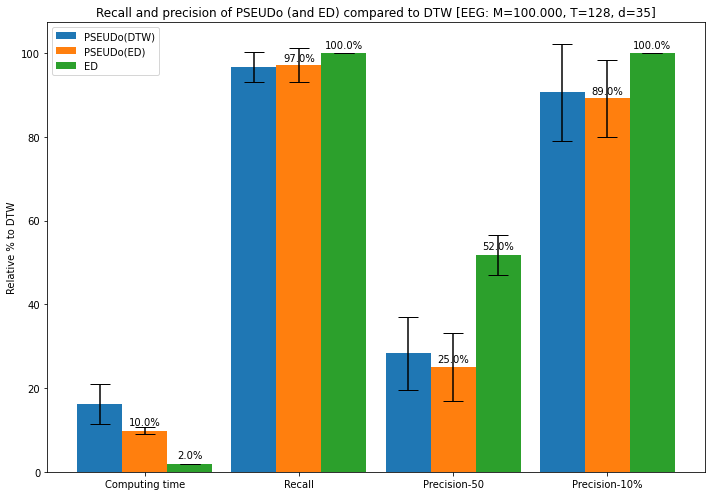

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['Computing time', 'Recall', 'Precision-50', 'Precision-10%']
pseudo_values = [
    100 * (np.mean(total_lsh_times) / np.mean(total_dtw_times)),
    100 * np.mean(total_recall_pseudo), 
    100 * np.mean(total_precision_pseudo), 
    100 * np.mean(total_precision2_pseudo)
]
pseudo_error = [
    100 * (np.std(total_lsh_times) / np.mean(total_dtw_times)), 
    100 * np.std(total_recall_pseudo), 
    100 * np.std(total_precision_pseudo), 
    100 * np.std(total_precision2_pseudo)
]
pseudo_ed_values = [
    100 * (np.mean(total_lsh_times_ed) / np.mean(total_dtw_times)),
    100 * np.mean(total_recall_pseudo_ed), 
    100 * np.mean(total_precision_pseudo_ed), 
    100 * np.mean(total_precision2_pseudo_ed)
]
pseudo_ed_error = [
    100 * (np.std(total_lsh_times_ed) / np.mean(total_dtw_times)), 
    100 * np.std(total_recall_pseudo_ed), 
    100 * np.std(total_precision_pseudo_ed), 
    100 * np.std(total_precision2_pseudo_ed)
]
ed_values = [
    100 * (np.mean(total_ed_times) / np.mean(total_dtw_times)),
    100 * np.mean(total_recall_ed), 
    100 * np.mean(total_precision_ed), 
    100 * np.mean(total_precision2_ed)
]
ed_error = [
    100 * (np.std(total_ed_times) / np.mean(total_dtw_times)), 
    100 * np.std(total_recall_ed), 
    100 * np.std(total_precision_ed), 
    100 * np.std(total_precision2_ed)
]

x = 1.2 * np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
rects1 = ax.bar(x - width, pseudo_values, width, yerr=pseudo_error, capsize=10, label='PSEUDo (DTW)')
rects1 = ax.bar(x, pseudo_ed_values, width, yerr=pseudo_ed_error, capsize=10, label='PSEUDo (ED)')
rects2 = ax.bar(x + width, ed_values, width, yerr=ed_error, capsize=10, label='ED')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Relative to DTW')
ax.set_title('Recall and precision of PSEUDo (and ED) compared to DTW [EEG: M=100.000, T=256, d=35]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),0)
        ax.annotate('{}'.format(height)+'%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()